In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.nn.quantized import functional as qF
import numpy as np
import cv2 as cv
import pytorch_lightning as pl
import torchvision
import torchvision.transforms.v2 as transforms
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics.functional import multiclass_accuracy
from torch.ao.quantization import QuantStub, DeQuantStub
import json

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [60]:
class DatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        # print(x)
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [61]:
transform_train = transforms.Compose([
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=False, download=True, transform=transform_test)

trainset = torchvision.datasets.CIFAR10(
    root='./CIFAR10', train=True, download=True)

# split the train set into train/validation
train_set_size = int(len(trainset) * 0.8)
valid_set_size = len(trainset) - train_set_size

seed = torch.Generator().manual_seed(42)
trainset, validset = torch.utils.data.random_split(trainset, [train_set_size, valid_set_size], generator=seed)

trainset = DatasetWrapper(trainset, transform_train)
validset = DatasetWrapper(validset, transform_test)

# Create train dataloader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=512, shuffle=True, num_workers=24)

# Create validation dataloader
validloader = torch.utils.data.DataLoader(
    validset, batch_size=512, shuffle=False, num_workers=24)

# Create test dataloader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=512, shuffle=False, num_workers=24)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


/home/semar/.local/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [62]:
class SeparableConv2d(nn.Module):
    '''Separable convolution'''
    def __init__(self, in_channels, out_channels, stride=1):
        super(SeparableConv2d, self).__init__()
        self.dw_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=False),
        )
        self.pw_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
        )

    def forward(self, x):
        print("input: ", x.size())
        x = self.dw_conv(x)
        print("depth conv output: ", x.size())
        x = self.pw_conv(x)
        print("pointwise conv output: ", x.size())
        return x

In [64]:
class MyMobileNet(pl.LightningModule):
    cfg = [
        (32, 64, 1), 
        (64, 128, 2), 
        (128, 128, 1), 
        (128, 256, 2),
        (256, 256, 1),
        (256, 512, 2),
        (512, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 512, 1),
        (512, 1024, 2),
        (1024, 1024, 1),
    ]
    
    def __init__(self, num_classes=10, alpha: float = 1):
        super(MyMobileNet, self).__init__()
        conv_out = int(32 * alpha)
        self.conv = nn.Conv2d(3, conv_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(conv_out)
        self.relu = nn.ReLU(inplace=False)
        # self.accuracy = Accuracy("multiclass", num_classes=num_classes)
        # self.accuracy = MulticlassAccuracy()
        self.accuracy = multiclass_accuracy

        self.features = self.make_feature_extractor(alpha)
        self.linear = nn.Linear(int(1024*alpha), num_classes)

    def make_feature_extractor(self, alpha):
        layer_values = [(int(inp*alpha), int(out*alpha), chan) for inp, out, chan in self.cfg]
        layers = nn.Sequential(*[SeparableConv2d(*tup) for tup in layer_values])
        return layers

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.features(x)
        x = F.avg_pool2d(x, 2)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        return x
        
    def step(self, batch, batch_idx):
    # def training_step(self):
        x, y = batch
        logits = self.forward(x)
        loss = self.compute_loss(logits, y)
        acc = self.accuracy(logits, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
    # def training_step(self):
        loss, acc = self.step(batch, batch_idx)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
    # def training_step(self):
        loss, acc = self.step(batch, batch_idx)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, acc = self.step(batch, batch_idx)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def configure_optimizers(self):
        self.lr = 0.02089
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.3, total_steps=MAX_EPOCHS * len(trainloader))
        return { "optimizer": optimizer, "lr_scheduler": scheduler }
        
    def compute_loss(self, logits, labels):
        return nn.functional.cross_entropy(logits, labels)

In [26]:
1024*0.75

768.0

In [33]:
trainer.fit(model, train_dataloaders=trainloader, val_dataloaders=validloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ conv     │ Conv2d      │    216 │
│ 1 │ bn       │ BatchNorm2d │     16 │
│ 2 │ relu     │ ReLU        │      0 │
│ 3 │ features │ Sequential  │  212 K │
│ 4 │ linear   │ Linear      │  2.6 K │
└───┴──────────┴─────────────┴────────┘

Trainable params: 215 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 215 K                                                                                                
Total estimated model params size (MB): 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=70` reached.


In [34]:
trainer.test(model, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7689999938011169     │
│         test_loss         │    0.6811059713363647     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6811059713363647, 'test_accuracy': 0.7689999938011169}]

In [35]:
MODEL_WEIGHTS_PATH = './checkpoints/model_small.pth'
QUANTIZED_MODEL_WEIGHTS_PATH = './checkpoints/quantized_small.pth'

In [36]:
print('==> saving model')
state = {
    'net': model.state_dict(),
    'acc': '0.747299',
    'epoch': 50,
}

torch.save(state, MODEL_WEIGHTS_PATH)

==> saving model


In [37]:
# Sanity test

saved = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(saved['state_dict'])
model.load_state_dict(saved['net'])
trainer.test(model, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7689999938011169     │
│         test_loss         │     0.68110591173172      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.68110591173172, 'test_accuracy': 0.7689999938011169}]

# Post Training Quantization!

In [65]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')


class QuantizedMobileNet(MyMobileNet):
    def __init__(self, num_classes=10, alpha: float = 1):
        super(QuantizedMobileNet, self).__init__(num_classes, alpha)
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        print("IMAGE SIZE: ", x.size())
        x = self.quant(x)
        x = self.conv(x)
        print("NORMAL CONVOLUTION OUTPUT SIZE: ", x.size())
        x = self.relu(self.bn(x))
        x = self.features(x)
        x = F.avg_pool2d(x, 2)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        x = self.dequant(x)
        return x
        
    def training_step(self, batch, batch_idx):
    # def training_step(self):
        loss, acc = self.step(batch, batch_idx)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def gen_circuit_input(self, image):
        x = self.quant(image)
        quantized_image = torch.int_repr(x).squeeze().numpy()
        quantized_weights = torch.int_repr(self.conv.weight()).numpy()
        out = self.conv(x)
        print(quantized_image)
        quantized_out = torch.int_repr(out).numpy()
        print(quantized_image.shape)
        # print(quantized_weights)
        input_json_path = "input.json"
        with open(input_json_path, "w") as input_file:
            json.dump({"in": quantized_image.tolist(),
                       "W": quantized_weights.tolist(),
                       
                      }, input_file)
        output_json_path = "output.json"
        with open(output_json_path, "w") as output_file:
            json.dump({"out": quantized_out.tolist(),
                       
                      }, output_file)

    def load_quantized(self, fp_weights_path, quant_weights_path):
        # create fp32 model
        fp_checkpoint = torch.load(fp_weights_path)
        self.load_state_dict(fp_checkpoint['net'])
        
        # quantize it without calibration (weights will not be final)
        self.eval()
        self.fuse_model()
        self.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        torch.ao.quantization.prepare(self, inplace=True)
        torch.quantization.convert(self, inplace=True)
        
        # load the real state dict
        int_checkpoint = torch.load(quant_weights_path)
        self.load_state_dict(int_checkpoint['net'])
        
    def gen_first_layer_input(self, image):
        x = self.quant(image)
        # quantized_image = torch.int_repr(x.squeeze().permute(1, 2, 0)).numpy() # (1, C, H, W) -> (H, W, C)
        quantized_image = torch.int_repr(x.squeeze()).numpy() # (1, C, H, W) -> (H, W, C)
        # quantized_image = torch.int_repr(x).squeeze().numpy() # (1, C, H, W) -> (C, H, W)
        quantized_weights = torch.int_repr(self.conv.weight()).numpy()
        bias = torch.zeros(quantized_weights.shape[0]).numpy().astype(int).tolist()
        out = self.conv(x)
        # print(quantized_image)
        print("INPUT SIZE: ", image.size())
        print("FIRST LAYER OUTPUT SIZE: ", out.size())
        quantized_out = torch.int_repr(out).numpy()
        print("QUANTIZED SHAPE: ", quantized_image.shape)
        print(quantized_weights.shape)
        input_json_path = "input.json"
        with open(input_json_path, "w") as input_file:
            # json.dump({"in": quantized_image.transpose(1, 2, 0).tolist(), # (C, H, W) -> (H, W, C)
            json.dump({"in": quantized_image.tolist(),
                       "weights": quantized_weights.tolist(),
                       "bias": bias,
                       
                      }, input_file)
        output_json_path = "output.json"
        with open(output_json_path, "w") as output_file:
            json.dump({"out": quantized_out.tolist(),
                       
                      }, output_file)

        return quantized_image, quantized_weights, bias, quantized_out
            

    # Fuse Conv+BN and Conv+BN+Relu modules prior to quantization
    # This operation does not change the numerics
    def fuse_model(self, is_qat=False):
        fuse_modules = torch.ao.quantization.fuse_modules_qat if is_qat else torch.ao.quantization.fuse_modules
        fuse_modules(self, ["conv", "bn", "relu"], inplace=True)
        for m in self.modules():
            if type(m) == SeparableConv2d:
                fuse_modules(m.dw_conv, ['0', '1', '2'], inplace=True)
                fuse_modules(m.pw_conv, ['0', '1', '2'], inplace=True)

In [41]:
# Baseline
model = QuantizedMobileNet(num_classes=10, alpha=0.25)
# model = MyMobileNet(num_classes=10, alpha=0.25)
saved = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(saved['state_dict'])
model.load_state_dict(saved['net'])
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)

trainer = pl.Trainer(callbacks=[progress_callback])

trainer.test(model, testloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Size (MB): 0.930354


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7689999938011169     │
│         test_loss         │    0.6811059713363647     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6811059713363647, 'test_accuracy': 0.7689999938011169}]

In [42]:
backend = "fbgemm"
# backend = "x86"
model = QuantizedMobileNet(num_classes=10, alpha=0.25)
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
model.load_state_dict(checkpoint['net'])
model.eval()

print('Before Training Quantization Prepare: Starting values')
print('\n Starting SeparableConv Block: \n\n', model.features[1].dw_conv)

model.fuse_model()
# model.qconfig = torch.ao.quantization.default_qconfig # This leads to bad results.
print('Before Training Quantization Prepare: Fusing model')
print('\n After fusing SeparableConv Block: \n\n', model.features[1].dw_conv)


model.qconfig = torch.quantization.get_default_qconfig(backend)

print(model.qconfig)

torch.ao.quantization.prepare(model, inplace=True)

# Calibrate first
print('Post Training Quantization Prepare: Inserting Observers')
print('\n SeparableConv Block:After observer insertion \n\n', model.features[1].dw_conv)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)

torch.ao.quantization.convert(model, inplace=True)

print('Post Training Quantization: Convert done')
print('\n SeparableConv Block: After fusion and quantization, note fused modules: \n\n', model.features[1].dw_conv)
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)
trainer.test(model, testloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Before Training Quantization Prepare: Starting values

 Starting SeparableConv Block: 

 Sequential(
  (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
Before Training Quantization Prepare: Fusing model

 After fusing SeparableConv Block: 

 Sequential(
  (0): ConvReLU2d(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16)
    (1): ReLU()
  )
  (1): Identity()
  (2): Identity()
)
QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Post Training Quantization Prepare: Inserting Observers

 SeparableConv Block:After observer insertion 

 Sequential(
  (0): ConvReLU2d(
    (0): Conv2d(16, 16, kern

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.766700029373169     │
│         val_loss          │    0.6789271235466003     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Post Training Quantization: Convert done

 SeparableConv Block: After fusion and quantization, note fused modules: 

 Sequential(
  (0): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(2, 2), scale=0.09753653407096863, zero_point=0, padding=(1, 1), groups=16)
  (1): Identity()
  (2): Identity()
)
Size (MB): 0.312596


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7633000016212463     │
│         val_loss          │    0.6854455471038818     │
└───────────────────────────┴───────────────────────────┘

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7649999856948853     │
│         test_loss         │    0.6883073449134827     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6883073449134827, 'test_accuracy': 0.7649999856948853}]

In [423]:
# print(model.qconfig) qconfig = torch.quantization.get_default_qconfig(backend)
QConfig(
    activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, 
    weight=functools.partial(
        <class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, 
        dtype=torch.qint8,
        qscheme=torch.per_channel_symmetric
    ){}
)

SyntaxError: invalid syntax (3580875543.py, line 3)

In [89]:
model.eval()
progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)
trainer.test(model, testloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8302000164985657     │
│         val_loss          │    0.5223873257637024     │
└───────────────────────────┴───────────────────────────┘

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8248000144958496     │
│         test_loss         │    0.5349059104919434     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5349059104919434, 'test_accuracy': 0.8248000144958496}]

In [43]:
# from torch.quantization import quantize_fx
import torch.quantization._numeric_suite as ns

float_model = QuantizedMobileNet(num_classes=10, alpha=0.25)
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
float_model.load_state_dict(checkpoint['net'])

wt_compare_dict = ns.compare_weights(float_model.state_dict(), model.state_dict())

print('keys of wt_compare_dict:')
print(wt_compare_dict.keys())

print("\nkeys of wt_compare_dict entry for conv1's weight:")
print(wt_compare_dict['conv.weight'].keys())
print(wt_compare_dict['conv.weight']['float'].shape)
print(wt_compare_dict['conv.weight']['quantized'].shape)

keys of wt_compare_dict:
dict_keys(['conv.weight', 'features.0.dw_conv.0.weight', 'features.0.pw_conv.0.weight', 'features.1.dw_conv.0.weight', 'features.1.pw_conv.0.weight', 'features.2.dw_conv.0.weight', 'features.2.pw_conv.0.weight', 'features.3.dw_conv.0.weight', 'features.3.pw_conv.0.weight', 'features.4.dw_conv.0.weight', 'features.4.pw_conv.0.weight', 'features.5.dw_conv.0.weight', 'features.5.pw_conv.0.weight', 'features.6.dw_conv.0.weight', 'features.6.pw_conv.0.weight', 'features.7.dw_conv.0.weight', 'features.7.pw_conv.0.weight', 'features.8.dw_conv.0.weight', 'features.8.pw_conv.0.weight', 'features.9.dw_conv.0.weight', 'features.9.pw_conv.0.weight', 'features.10.dw_conv.0.weight', 'features.10.pw_conv.0.weight', 'features.11.dw_conv.0.weight', 'features.11.pw_conv.0.weight', 'features.12.dw_conv.0.weight', 'features.12.pw_conv.0.weight', 'linear._packed_params._packed_params'])

keys of wt_compare_dict entry for conv1's weight:
dict_keys(['float', 'quantized'])
torch.Size(

In [44]:
def compute_error(x, y):
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)

for key in wt_compare_dict:
    print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))

conv.weight tensor(2.6870)
features.0.dw_conv.0.weight tensor(3.2299)
features.0.pw_conv.0.weight tensor(5.5976)
features.1.dw_conv.0.weight tensor(6.9173)
features.1.pw_conv.0.weight tensor(6.4617)
features.2.dw_conv.0.weight tensor(6.2098)
features.2.pw_conv.0.weight tensor(3.1022)
features.3.dw_conv.0.weight tensor(3.8423)
features.3.pw_conv.0.weight tensor(3.0854)
features.4.dw_conv.0.weight tensor(6.7424)
features.4.pw_conv.0.weight tensor(2.7227)
features.5.dw_conv.0.weight tensor(3.8985)
features.5.pw_conv.0.weight tensor(2.2009)
features.6.dw_conv.0.weight tensor(5.4713)
features.6.pw_conv.0.weight tensor(2.1605)
features.7.dw_conv.0.weight tensor(-12.9990)
features.7.pw_conv.0.weight tensor(2.1129)
features.8.dw_conv.0.weight tensor(-21.8424)
features.8.pw_conv.0.weight tensor(1.9015)
features.9.dw_conv.0.weight tensor(-21.6515)
features.9.pw_conv.0.weight tensor(2.0899)
features.10.dw_conv.0.weight tensor(-18.4464)
features.10.pw_conv.0.weight tensor(1.8470)
features.11.dw_co

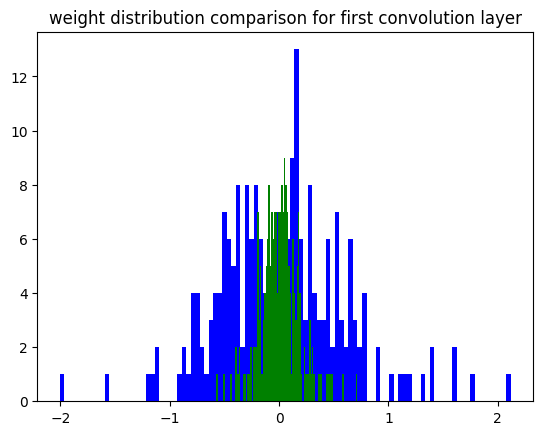

In [45]:
import matplotlib.pyplot as plt

f = wt_compare_dict['conv.weight']['float'].flatten()
plt.hist(f, bins = 100, color='blue')
plt.title("weight distribution comparison for first convolution layer")
# plt.show()

q = wt_compare_dict['conv.weight']['quantized'].dequantize().flatten()
plt.hist(q, bins = 100, color='green')
# plt.title("Quantized model weights of conv")
plt.show()

# Quantization with fusing model

In [12]:
backend = "fbgemm"
# backend = "x86"
model = QuantizedMobileNet()
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
model.load_state_dict(checkpoint['net'])
model.eval()
model.fuse_model()
# model.qconfig = torch.ao.quantization.default_qconfig # This leads to bad results.

# model.qconfig = torch.quantization.get_default_qconfig(backend)
model.qconfig = torch.quantization.qconfig.QConfig(activation=torch.quantization.observer.HistogramObserver.with_args(reduce_range=True),
                  weight=torch.quantization.observer.MovingAveragePerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric))
                  # weight=torch.quantization.observer.PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric))

print(model.qconfig)

torch.ao.quantization.prepare(model, inplace=True)

# Calibrate first
print('Post Training Quantization Prepare: Inserting Observers')
print('\n SeparableConv Block:After observer insertion \n\n', model.features[1].dw_conv)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)

torch.ao.quantization.convert(model, inplace=True)

print('Post Training Quantization: Convert done')
print('\n SeparableConv Block: After fusion and quantization, note fused modules: \n\n', model.features[1].dw_conv)
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)
trainer.test(model, testloader)

/home/semar/.local/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Post Training Quantization Prepare: Inserting Observers

 SeparableConv Block:After observer insertion 

 Sequential(
  (0): ConvReLU2d(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
    (1): ReLU()
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (1): Identity()
  (2): Identity()
)


/home/semar/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Output()

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([272, 32, 32, 32])

depth conv output:  torch.Size([272, 32, 32, 32])

pointwise conv output:  torch.Size([272, 64, 32, 32])

input:  torch.Size([272, 64, 32, 32])

depth conv output:  torch.Size([272, 64, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

input:  torch.Size([272, 1024, 2, 2])

depth conv output:  torch.Size([272, 1024, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8411999940872192     │
│         val_loss          │     0.473789781332016     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Post Training Quantization: Convert done

 SeparableConv Block: After fusion and quantization, note fused modules: 

 Sequential(
  (0): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.1215631514787674, zero_point=0, padding=(1, 1), groups=64)
  (1): Identity()
  (2): Identity()
)
Size (MB): 3.461908


Output()

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([272, 32, 32, 32])

depth conv output:  torch.Size([272, 32, 32, 32])

pointwise conv output:  torch.Size([272, 64, 32, 32])

input:  torch.Size([272, 64, 32, 32])

depth conv output:  torch.Size([272, 64, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

input:  torch.Size([272, 1024, 2, 2])

depth conv output:  torch.Size([272, 1024, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.8382999897003174     │
│         val_loss          │    0.48289868235588074    │
└───────────────────────────┴───────────────────────────┘

Output()

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 32, 32, 32])

depth conv output:  torch.Size([512, 32, 32, 32])

pointwise conv output:  torch.Size([512, 64, 32, 32])

input:  torch.Size([512, 64, 32, 32])

depth conv output:  torch.Size([512, 64, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 16, 16])

pointwise conv output:  torch.Size([512, 128, 16, 16])

input:  torch.Size([512, 128, 16, 16])

depth conv output:  torch.Size([512, 128, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 8, 8])

pointwise conv output:  torch.Size([512, 256, 8, 8])

input:  torch.Size([512, 256, 8, 8])

depth conv output:  torch.Size([512, 256, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 4, 4])

pointwise conv output:  torch.Size([512, 512, 4, 4])

input:  torch.Size([512, 512, 4, 4])

depth conv output:  torch.Size([512, 512, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([512, 1024, 2, 2])

depth conv output:  torch.Size([512, 1024, 2, 2])

pointwise conv output:  torch.Size([512, 1024, 2, 2])

input:  torch.Size([272, 32, 32, 32])

depth conv output:  torch.Size([272, 32, 32, 32])

pointwise conv output:  torch.Size([272, 64, 32, 32])

input:  torch.Size([272, 64, 32, 32])

depth conv output:  torch.Size([272, 64, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 16, 16])

pointwise conv output:  torch.Size([272, 128, 16, 16])

input:  torch.Size([272, 128, 16, 16])

depth conv output:  torch.Size([272, 128, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 8, 8])

pointwise conv output:  torch.Size([272, 256, 8, 8])

input:  torch.Size([272, 256, 8, 8])

depth conv output:  torch.Size([272, 256, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 4, 4])

pointwise conv output:  torch.Size([272, 512, 4, 4])

input:  torch.Size([272, 512, 4, 4])

depth conv output:  torch.Size([272, 512, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

input:  torch.Size([272, 1024, 2, 2])

depth conv output:  torch.Size([272, 1024, 2, 2])

pointwise conv output:  torch.Size([272, 1024, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8367999792098999     │
│         test_loss         │    0.5063580274581909     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5063580274581909, 'test_accuracy': 0.8367999792098999}]

In [49]:
print('==> saving quantized model')
state = {
    'net': model.state_dict(),
}

torch.save(state, QUANTIZED_MODEL_WEIGHTS_PATH)

==> saving quantized model


# Quantization without fusing model

In [66]:
backend = "fbgemm"
# backend = "x86"
model = QuantizedMobileNet(num_classes=10, alpha=0.25)
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
model.load_state_dict(checkpoint['net'])
model.eval()

print('Before Training Quantization Prepare: Starting values')
print('\n Starting SeparableConv Block: \n\n', model.features[1].dw_conv)

# model.fuse_model()
# model.qconfig = torch.ao.quantization.default_qconfig # This leads to bad results.
# print('Before Training Quantization Prepare: Fusing model')
# print('\n After fusing SeparableConv Block: \n\n', model.features[1].dw_conv)


model.qconfig = torch.quantization.get_default_qconfig(backend)

print(model.qconfig)

torch.ao.quantization.prepare(model, inplace=True)

# Calibrate first
print('Post Training Quantization Prepare: Inserting Observers')
print('\n SeparableConv Block:After observer insertion \n\n', model.features[1].dw_conv)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)

torch.ao.quantization.convert(model, inplace=True)

print('Post Training Quantization: Convert done')
print('\n SeparableConv Block: After fusion and quantization, note fused modules: \n\n', model.features[1].dw_conv)
print_size_of_model(model)

progress_callback = RichProgressBar(leave=True)
trainer = pl.Trainer(accelerator="cpu", callbacks=[progress_callback])

trainer.validate(model, validloader)
trainer.test(model, testloader)

/home/semar/.local/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Before Training Quantization Prepare: Starting values

 Starting SeparableConv Block: 

 Sequential(
  (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Post Training Quantization Prepare: Inserting Observers

 SeparableConv Block:After observer insertion 

 Sequential(
  (0): Conv2d(
    16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (1): BatchNorm2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): HistogramO

/home/semar/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Output()

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([272, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([272, 8, 32, 32])

input:  torch.Size([272, 8, 32, 32])

depth conv output:  torch.Size([272, 8, 32, 32])

pointwise conv output:  torch.Size([272, 16, 32, 32])

input:  torch.Size([272, 16, 32, 32])

depth conv output:  torch.Size([272, 16, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

input:  torch.Size([272, 256, 2, 2])

depth conv output:  torch.Size([272, 256, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │     0.766700029373169     │
│         val_loss          │    0.6789270639419556     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Post Training Quantization: Convert done

 SeparableConv Block: After fusion and quantization, note fused modules: 

 Sequential(
  (0): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), scale=0.5261287093162537, zero_point=33, padding=(1, 1), groups=16, bias=False)
  (1): QuantizedBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
Size (MB): 0.389034


Output()

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([272, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([272, 8, 32, 32])

input:  torch.Size([272, 8, 32, 32])

depth conv output:  torch.Size([272, 8, 32, 32])

pointwise conv output:  torch.Size([272, 16, 32, 32])

input:  torch.Size([272, 16, 32, 32])

depth conv output:  torch.Size([272, 16, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

input:  torch.Size([272, 256, 2, 2])

depth conv output:  torch.Size([272, 256, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7497000098228455     │
│         val_loss          │    0.7422574758529663     │
└───────────────────────────┴───────────────────────────┘

Output()

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([512, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([512, 8, 32, 32])

input:  torch.Size([512, 8, 32, 32])

depth conv output:  torch.Size([512, 8, 32, 32])

pointwise conv output:  torch.Size([512, 16, 32, 32])

input:  torch.Size([512, 16, 32, 32])

depth conv output:  torch.Size([512, 16, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 16, 16])

pointwise conv output:  torch.Size([512, 32, 16, 16])

input:  torch.Size([512, 32, 16, 16])

depth conv output:  torch.Size([512, 32, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 8, 8])

pointwise conv output:  torch.Size([512, 64, 8, 8])

input:  torch.Size([512, 64, 8, 8])

depth conv output:  torch.Size([512, 64, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 4, 4])

pointwise conv output:  torch.Size([512, 128, 4, 4])

input:  torch.Size([512, 128, 4, 4])

depth conv output:  torch.Size([512, 128, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

input:  torch.Size([512, 256, 2, 2])

depth conv output:  torch.Size([512, 256, 2, 2])

pointwise conv output:  torch.Size([512, 256, 2, 2])

IMAGE SIZE:  torch.Size([272, 3, 32, 32])

NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([272, 8, 32, 32])

input:  torch.Size([272, 8, 32, 32])

depth conv output:  torch.Size([272, 8, 32, 32])

pointwise conv output:  torch.Size([272, 16, 32, 32])

input:  torch.Size([272, 16, 32, 32])

depth conv output:  torch.Size([272, 16, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 16, 16])

pointwise conv output:  torch.Size([272, 32, 16, 16])

input:  torch.Size([272, 32, 16, 16])

depth conv output:  torch.Size([272, 32, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 8, 8])

pointwise conv output:  torch.Size([272, 64, 8, 8])

input:  torch.Size([272, 64, 8, 8])

depth conv output:  torch.Size([272, 64, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 4, 4])

pointwise conv output:  torch.Size([272, 128, 4, 4])

input:  torch.Size([272, 128, 4, 4])

depth conv output:  torch.Size([272, 128, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

input:  torch.Size([272, 256, 2, 2])

depth conv output:  torch.Size([272, 256, 2, 2])

pointwise conv output:  torch.Size([272, 256, 2, 2])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7483999729156494     │
│         test_loss         │    0.7413896918296814     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7413896918296814, 'test_accuracy': 0.7483999729156494}]

In [68]:
print("Normal Conv weights size: ", model.conv.weight().size())
print("Depthwise conv size: ", model.features[0].dw_conv[0].weight().size())
print("Pointiwse conv size: ", model.features[0].pw_conv[0].weight().size())

Normal Conv weights size:  torch.Size([8, 3, 3, 3])
Depthwise conv size:  torch.Size([8, 1, 3, 3])
Pointiwse conv size:  torch.Size([16, 8, 1, 1])


In [69]:
logits = model(image)
pred = logits.argmax()
classes[pred]

# input size                 x weight size              == output size
# torch.Size([1, 3, 32, 32]) x torch.Size([8, 3, 3, 3]) == torch.Size([1, 8, 32, 32]) # initial convolution layer
# torch.Size([1, 8, 32, 32]) x torch.Size([8, 1, 3, 3]) == torch.Size([1, 8, 32, 32]) # depthwise convolution
# torch.Size([1, 8, 32, 32]) x torch.Size([16, 8, 1, 1] == torch.Size([1, 16, 32, 32]) # pointwise convolution

IMAGE SIZE:  torch.Size([1, 3, 32, 32])
NORMAL CONVOLUTION OUTPUT SIZE:  torch.Size([1, 8, 32, 32])
input:  torch.Size([1, 8, 32, 32])
depth conv output:  torch.Size([1, 8, 32, 32])
pointwise conv output:  torch.Size([1, 16, 32, 32])
input:  torch.Size([1, 16, 32, 32])
depth conv output:  torch.Size([1, 16, 16, 16])
pointwise conv output:  torch.Size([1, 32, 16, 16])
input:  torch.Size([1, 32, 16, 16])
depth conv output:  torch.Size([1, 32, 16, 16])
pointwise conv output:  torch.Size([1, 32, 16, 16])
input:  torch.Size([1, 32, 16, 16])
depth conv output:  torch.Size([1, 32, 8, 8])
pointwise conv output:  torch.Size([1, 64, 8, 8])
input:  torch.Size([1, 64, 8, 8])
depth conv output:  torch.Size([1, 64, 8, 8])
pointwise conv output:  torch.Size([1, 64, 8, 8])
input:  torch.Size([1, 64, 8, 8])
depth conv output:  torch.Size([1, 64, 4, 4])
pointwise conv output:  torch.Size([1, 128, 4, 4])
input:  torch.Size([1, 128, 4, 4])
depth conv output:  torch.Size([1, 128, 4, 4])
pointwise conv outp

'cat'

# Testing convolution algorithm

In [578]:
image, label = testset[0]

test_model = QuantizedMobileNet(num_classes=10, alpha=0.25)
checkpoint = torch.load(MODEL_WEIGHTS_PATH)
# model.load_state_dict(checkpoint['state_dict'])
test_model.load_state_dict(checkpoint['net'])
test_model.eval()

expected = test_model.conv(image)
expected = test_model.features[0].dw_conv[0](expected).detach().numpy()
weights = test_model.features[0].dw_conv[0].weight.detach().numpy()
expected.shape, weights.shape

((8, 32, 32), (8, 1, 3, 3))

# Testing normal convolution output

In [606]:
CIRCOM_PRIME = 21888242871839275222246405745257275088548364400416034343698204186575808495617
def from_circom(x: int):
    CIRCOM_PRIME = 21888242871839275222246405745257275088548364400416034343698204186575808495617
    return x - CIRCOM_PRIME
    
def to_circom(x):
    CIRCOM_PRIME = 21888242871839275222246405745257275088548364400416034343698204186575808495617
    if x < 0:
        return x + CIRCOM_PRIME
    return x
    
def Conv2DInt(nRows, nCols, nChannels, nFilters, kernelSize, strides, input, weights, bias):
    remainder = [[[None for _ in range(nFilters)] for _ in range((nCols - kernelSize)//strides + 1)] for _ in range((nRows - kernelSize)//strides + 1)]
    outRows = (nRows - kernelSize)//strides + 1
    outCols = (nCols - kernelSize)//strides + 1
    print("image size: ", input.shape)
    out = np.zeros((nFilters, outRows, outCols))
    print("out size: ", out.shape)
    # convolution per filter
    for rows in range(outRows):
        for cols in range(outCols):
            for filter in range(nFilters):
                for k in range(nChannels):
                    for x in range(kernelSize):
                        for y in range(kernelSize):
                            out[filter, rows, cols] += input[k, rows*strides+x, cols*strides+y] * weights[filter, k, x, y]
                            
    return out, remainder
    
weights = test_model.conv.weight.detach().numpy()
bias = torch.zeros(weights.shape[0]).numpy()
expected = test_model.conv(image).detach().numpy()
# expected = test_model.features[0].dw_conv[0](conv_input).detach().numpy()
# actual, _ = Conv2DInt(34, 34, 3, 32, 3, 1, pad(image, 1), weights, bias)
actual, _ = Conv2DInt(34, 34, 3, 8, 3, 1, pad(image, 1), weights, bias)

assert(np.allclose(expected, actual, atol=0.00001))

image size:  (3, 34, 34)
out size:  (8, 32, 32)


In [569]:
test_model.conv.weight.shape

torch.Size([8, 3, 3, 3])

In [608]:
EXPONENT = 10

expected = test_model.conv(image).detach().numpy()

print("expected result shape: ", expected.shape)

padded = pad(image, 1)
naive_quantized_image = padded * 10**EXPONENT
print("quantized input shape: ", naive_quantized_image.shape)
naive_quantized_weights = weights * 10**EXPONENT

# actual, _ = Conv2DInt(34, 34, 8, 8, 3, 1, padded, weights, bias)

# naive_output, _ = Conv2DInt(34, 34, 8, 8, 3, 1, naive_quantized_image, naive_quantized_weights, bias)
naive_output, _ = Conv2DInt(34, 34, 3, 8, 3, 1, naive_quantized_image, naive_quantized_weights, bias)

print("actual result shape: ", naive_output.shape)

assert(np.allclose((naive_output / 10**(2*EXPONENT)).astype(np.float32), expected, atol=0.00001))

circuit_input = naive_quantized_image.round().transpose((1, 2, 0))

print("circuit input shape: ", circuit_input.shape)

circuit_weights = naive_quantized_weights.transpose((2, 3, 1, 0))

print("circuit weights shape: ", circuit_weights.shape)

input_json_path = "standard_conv_input.json"
with open(input_json_path, "w") as input_file:
    json.dump({"in": naive_quantized_image.round().tolist(), # 'in' needs to be H x W x C
               "weights": naive_quantized_weights.round().tolist(), # 'weights' need to be H x W x C x nFilters
               "bias": bias.astype(int).tolist()}, 
              input_file)

expected result shape:  (8, 32, 32)
quantized input shape:  (3, 34, 34)
image size:  (3, 34, 34)
out size:  (8, 32, 32)
actual result shape:  (8, 32, 32)
circuit input shape:  (34, 34, 3)
circuit weights shape:  (3, 3, 3, 8)


In [609]:
public_json_path = "circuits/std_conv_public.json"
with open(public_json_path, "r") as input_file:
    circuit_output = json.load(input_file)

circuit_output = [from_circom(int(x)) for x in circuit_output]
print(len(circuit_output))
print(circuit_output[0] / 10**(2*EXPONENT))
print(expected[0][0][0])
# circuit_output = np.array(circuit_output).reshape(8, 32, 32)
circuit_output = np.array(circuit_output).reshape(32, 32, 8)
circuit_output = circuit_output.reshape(8, 32, 32)
circuit_output = circuit_output / 10**(2*EXPONENT)

# circuit_output = circuit_output.transpose((2, 0, 1))
assert(np.allclose(circuit_output.astype(np.float64), expected, atol=0.00001))
# circuit_output = circuit_output.apply(lambda x: int(x))
# circuit_output = circuit_output. (lambda x: int(x))
# circuit_output.astype(np.int64)

8192
-1.6224863924815682
-3.4272234


AssertionError: 

In [591]:
circuit_output[0][0]

array([-1.6224864388264026, -0.45286846482701737, -0.4121366517116064,
       -0.18018697459138766, -2.1888242871839277e+56,
       -2.1888242871839277e+56, -2.1888242871839277e+56,
       -0.1303278689649737, -2.2600309026671526, -1.897439566403069,
       -0.7046562471296296, -0.1958979762550507, -2.1888242871839277e+56,
       -2.1888242871839277e+56, -2.1888242871839277e+56,
       -1.2096855647801017, -1.9588105582575908, -2.2236318523103846,
       -0.24401384515534894, -2.1888242871839277e+56,
       -2.1888242871839277e+56, -2.1888242871839277e+56,
       -0.03517977574208236, -2.002807159823261, -2.4947395064408524,
       -2.5745374001404664, -2.1888242871839277e+56,
       -2.1888242871839277e+56, -0.12545389592660533,
       -2.1888242871839277e+56, -2.1888242871839277e+56,
       -1.26894654688526], dtype=object)

In [592]:
expected[0][0]

array([-3.4272234, -4.719599 , -4.129337 , -3.4475625, -4.3519626,
       -4.967033 , -4.215365 , -4.5386705, -4.389921 , -4.93638  ,
       -4.562378 , -4.131725 , -4.3016505, -4.4046535, -4.4085374,
       -4.529804 , -4.668953 , -5.026812 , -4.8707433, -4.255479 ,
       -4.3404827, -4.4884253, -4.487918 , -4.894562 , -4.469598 ,
       -5.2067256, -5.210048 , -5.631367 , -5.598993 , -5.90661  ,
       -6.151553 , -7.6800213], dtype=float32)

# Testing depthwise convolution output

In [552]:
# Receives H x W x C inputs/weights
def DepthwiseConv(nRows, nCols, nChannels, nFilters, kernelSize, strides, input, weights, bias):
    # out = np.array([[[0 for _ in range(nFilters)] for _ in range((nCols - kernelSize)//strides + 1)] for _ in range((nRows - kernelSize)//strides + 1)])
    assert(nFilters % nChannels == 0)
    remainder = [[[None for _ in range(nFilters)] for _ in range((nCols - kernelSize)//strides + 1)] for _ in range((nRows - kernelSize)//strides + 1)]
    outRows = (nRows - kernelSize)//strides + 1
    outCols = (nCols - kernelSize)//strides + 1
    # out = np.zeros((nFilters, outRows, outCols))
    out = np.zeros((outRows, outCols, nFilters))
    # convolution per filter
    for rows in range(outRows):
        for cols in range(outCols):
            for k in range(nChannels):
                for x in range(kernelSize):
                    for y in range(kernelSize):
                        # out[k, rows, cols] += input[k, rows*strides+x, cols*strides+y] * weights[k, x, y]
                        out[rows, cols, k] += input[rows*strides+x, cols*strides+y, k] * weights[x, y, k]
                            
    return out, remainder
    
weights = test_model.features[0].dw_conv[0].weight.squeeze().detach().numpy()
bias = torch.zeros(weights.shape[0]).numpy()
input = test_model.conv(image).detach()
padded = pad(input, 1)
expected = test_model.features[0].dw_conv[0](input).detach().numpy()
expected = expected.transpose((1, 2, 0))

print("padded shape: ", padded.shape)
print("weights shape: ", weights.shape)

# Converting to H x W x C
padded = padded.transpose((1, 2, 0))
weights = weights.transpose((1, 2, 0))

print("padded shape: ", padded.shape)
print("weights shape: ", weights.shape)

actual, _ = DepthwiseConv(34, 34, 8, 8, 3, 1, padded, weights, bias)
print("actual shape: ", actual.shape)

assert(np.allclose(expected, actual, atol=0.00001))

padded shape:  (8, 34, 34)
weights shape:  (8, 3, 3)
padded shape:  (34, 34, 8)
weights shape:  (3, 3, 8)
actual shape:  (32, 32, 8)


In [553]:
EXPONENT = 10

actual, _ = DepthwiseConv(34, 34, 8, 8, 3, 1, padded, weights, bias)

naive_quantized_image = padded * 10**EXPONENT
naive_quantized_weights = weights * 10**EXPONENT
naive_output, _ = DepthwiseConv(34, 34, 8, 8, 3, 1, naive_quantized_image, naive_quantized_weights, bias)

assert(np.allclose((naive_output / 10**(2*EXPONENT)).astype(np.float32), expected, atol=0.00001))

input_json_path = "test.json"
print(type(naive_quantized_image))
print(type(naive_quantized_weights))
print(type(bias))

print("Image shape: ", naive_quantized_image.shape)
print("Weight shape: ", naive_quantized_weights.shape)
print("bias shape: ", bias.shape)

rounded_expected, _ = DepthwiseConv(34, 34, 8, 8, 3, 1, naive_quantized_image.round(), naive_quantized_weights.round(), bias)
assert(np.allclose((rounded_expected / 10**(2*EXPONENT)).astype(np.float32), actual, atol=0.00001))

# Converting to H x W x C
# naive_quantized_image = naive_quantized_image.transpose((1, 2, 0))
# naive_quantized_weights = naive_quantized_weights.squeeze().transpose((1, 2, 0))
# naive_quantized_weights = naive_quantized_weights.reshape((1, 2, 0))
# naive_quantized_weights = weights.numpy() * 10**EXPONENT

# print("Image shape: ", naive_quantized_image.shape)
# print("Weight shape: ", naive_quantized_weights.shape)
# print("bias shape: ", bias.shape)

with open(input_json_path, "w") as input_file:
    json.dump({"in": naive_quantized_image.round().tolist(),
               "weights": naive_quantized_weights.round().tolist(),
               "bias": bias.astype(int).tolist()}, 
              input_file)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Image shape:  (34, 34, 8)
Weight shape:  (3, 3, 8)
bias shape:  (8,)


In [427]:
32*32*8

8192

In [556]:
input = test_model.conv(image).detach()
padded = pad(input, 1)
expected = test_model.features[0].dw_conv[0](input).detach().numpy()
expected = expected.transpose((1, 2, 0))

with open(input_json_path, "r") as input_file:
    test = json.load(input_file)

sanity_image = np.array(test['in'])
sanity_weights = np.array(test['weights'])
sanity_bias = np.array(test['bias'])
print("Image shape: ", sanity_image.shape)
print("Weight shape: ", sanity_weights.shape)
print("bias shape: ", sanity_bias.shape)
print("Expected shape: ", expected.shape)

sanity_expected, _ = DepthwiseConv(34, 34, 8, 8, 3, 1, sanity_image, sanity_weights, sanity_bias)

assert(np.allclose((sanity_expected / 10**(2*EXPONENT)).astype(np.float64), expected, atol=0.00001))

public_json_path = "circuits/public.json"
with open(public_json_path, "r") as input_file:
    circuit_output = json.load(input_file)

circuit_output = [int(x) for x in circuit_output]
print(circuit_output[0])
circuit_output = np.array(circuit_output).reshape(32, 32, 8)
circuit_output = circuit_output / 10**(2*EXPONENT)

# circuit_output = circuit_output.transpose((2, 0, 1))
assert(np.allclose(circuit_output.astype(np.float64), expected, atol=0.00001))
# circuit_output = circuit_output.apply(lambda x: int(x))
# circuit_output = circuit_output. (lambda x: int(x))
# circuit_output.astype(np.int64)

Image shape:  (34, 34, 8)
Weight shape:  (3, 3, 8)
bias shape:  (8,)
Expected shape:  (32, 32, 8)
21888242871839275222246405745257275088548364400416034343499536541726456843964


AssertionError: 

In [548]:
circuit_output[0][0][0]

2.1888242871839277e+56

In [542]:
circuit_output

array([[[2.1888242871839277e+56, 2.3632223609738867,
         2.1888242871839277e+56, ..., 2.1888242871839277e+56,
         2.1888242871839277e+56, 2.1888242871839277e+56],
        [0.20196927996296263, 2.1888242871839277e+56,
         2.1888242871839277e+56, ..., 5.660293342639877,
         2.1888242871839277e+56, 3.888962284742129],
        [2.1888242871839277e+56, 2.1888242871839277e+56,
         2.1888242871839277e+56, ..., 10.493192937727674,
         8.098754581746547, 2.1888242871839277e+56],
        ...,
        [2.1888242871839277e+56, 8.28239355818218,
         2.1888242871839277e+56, ..., 2.1888242871839277e+56,
         2.1888242871839277e+56, 8.892498168134782],
        [2.1888242871839277e+56, 11.07467360277363, 4.798437163832457,
         ..., 4.597137436333954, 2.0905612679119105,
         2.1888242871839277e+56],
        [2.1888242871839277e+56, 11.062931406541752, 11.303464853285655,
         ..., 2.2941149094424245, 0.5281483393939321, 3.683931878048128]],

       [[

In [541]:
expected[0][0]

array([ 4.9621572e+00,  6.9082391e-01, -1.2835680e+00,  3.4626499e-01,
        1.7523836e+00,  2.5954992e-03, -4.9571770e-01,  2.5360796e-01,
        4.4024709e-01,  1.9537285e-01, -8.4001952e-01, -1.8790640e-01,
        3.6377689e-01,  8.6404487e-02,  4.5987856e-02,  2.7415529e-01,
        6.8560034e-01,  4.3498442e-01, -7.1333635e-01, -5.4392540e-01,
        3.5501665e-01,  6.9096513e-02,  4.8216259e-01,  4.0910594e-02,
        3.9414290e-01,  1.0248792e+00,  3.6087978e-01,  2.7380151e-01,
        3.1500715e-01,  6.5058482e-01,  1.8911324e+00, -6.4629011e+00],
      dtype=float32)

In [540]:
sanit

NameError: name 'sanit' is not defined

In [449]:
sanity_expected[0]

array([[ 4.96215713e+20,  6.90823783e+19, -1.28356819e+20, ...,
         6.50584898e+19,  1.89113219e+20, -6.46290141e+20],
       [ 6.24248437e+20,  1.53961226e+20, -1.91911638e+20, ...,
         6.38811345e+19,  2.25547195e+20, -6.47458281e+20],
       [ 5.70866207e+20,  1.80258397e+20, -1.08760253e+20, ...,
         3.20491447e+19,  2.30234111e+20, -5.04286142e+20],
       ...,
       [-1.93558543e+20,  4.99656866e+20,  6.56103638e+19, ...,
         6.13603184e+20,  4.96531121e+20, -3.49818495e+20],
       [-2.84477531e+20,  3.21746852e+20,  2.61127707e+20, ...,
         2.85869636e+20,  4.46637868e+20,  1.53687084e+20],
       [-1.01879283e+19,  9.39380884e+19,  2.82819136e+20, ...,
         2.04075920e+20,  6.32868134e+19, -7.95149834e+19]])

In [448]:
circuit_output[0]

array([[2.18882429e+76, 2.36322236e+20, 2.18882429e+76, ...,
        2.18882429e+76, 2.18882429e+76, 2.18882429e+76],
       [2.93421894e+20, 6.42223622e+20, 3.67073277e+20, ...,
        1.27964834e+20, 2.18882429e+76, 2.18882429e+76],
       [4.60126062e+20, 1.07106639e+21, 1.11416588e+20, ...,
        2.18882429e+76, 3.41820818e+20, 2.18882429e+76],
       ...,
       [2.18882429e+76, 2.18882429e+76, 2.18882429e+76, ...,
        2.90163000e+20, 8.01227901e+20, 1.39928046e+20],
       [2.18882429e+76, 2.18882429e+76, 1.57259019e+20, ...,
        2.18882429e+76, 1.50678606e+20, 2.18882429e+76],
       [2.18882429e+76, 2.18882429e+76, 4.21208800e+20, ...,
        3.44895122e+20, 2.18882429e+76, 2.18882429e+76]])

# Testing pointwise convolution output

# 

In [291]:
def PointwiseConv2d(nRows, nCols, nChannels, nFilters, kernelSize, strides, input, weights, bias):
    # out = np.array([[[0 for _ in range(nFilters)] for _ in range((nCols - kernelSize)//strides + 1)] for _ in range((nRows - kernelSize)//strides + 1)])
    remainder = [[[None for _ in range(nFilters)] for _ in range((nCols - kernelSize)//strides + 1)] for _ in range((nRows - kernelSize)//strides + 1)]
    outRows = (nRows - kernelSize)//strides + 1
    outCols = (nCols - kernelSize)//strides + 1
    print("image size: ", input.shape)
    out = np.zeros((nFilters, outRows, outCols))
    print("out size: ", out.shape)
    # convolution per filter
    for rows in range(outRows):
        for cols in range(outCols):
            for filter in range(nFilters):
                for k in range(nChannels):
                    out[filter, rows, cols] += input[k, rows*strides, cols*strides] * weights[filter, k, 0, 0]
                            
    return out, remainder
    
weights = test_model.features[0].pw_conv[0].weight.detach()
bias = torch.zeros(weights.shape[0]).numpy()
print("image shape: ", image.shape)
input = test_model.conv(image).detach()
print("input shape: ", input.shape)
input = test_model.features[0].dw_conv[0](input)
# input = input[:, :1, :1]
# padded = pad(input, 1)
print("input shape: ", input.shape)
expected = test_model.features[0].pw_conv[0](input).detach().numpy()

print("weights shape: ", weights.shape)

# actual, _ = PointwiseConv(34, 34, 8, 8, 3, 1, padded, weights, bias)
actual, _ = PointwiseConv2d(32, 32, 8, 16, 1, 1, input, weights, bias)
print("expected shape: ", expected.shape)
print("actual shape: ", actual.shape)

assert(np.allclose(expected, actual, atol=0.00001))

image shape:  torch.Size([3, 32, 32])
input shape:  torch.Size([8, 32, 32])
input shape:  torch.Size([8, 32, 32])
weights shape:  torch.Size([16, 8, 1, 1])
image size:  torch.Size([8, 32, 32])
out size:  (16, 32, 32)
expected shape:  (16, 32, 32)
actual shape:  (16, 32, 32)


In [829]:
# quantized_image = model.quant(image)
# quantized_image_np = torch.int_repr(quantized_image.squeeze()).numpy()
# quantized_weights = model.conv.weight()
# quantized_weights_np = torch.int_repr(model.conv.weight()).numpy()
# expected = model.conv(quantized_image)
# expected_np = torch.int_repr(expected.squeeze()).numpy()
# quantized_image.shape, expected_np.shape

(torch.Size([1, 3, 32, 32]), (32, 32, 32))

In [785]:
actual, _ = Conv2DInt(34, 34, 3, 32, 3, 1, pad(quantized_image_np, 1), quantized_weights_np, bias)

In [862]:
scale = quantized_weights[0][0][0].q_scale()
zero = quantized_weights[0][0][0].q_zero_point()
print(quantized_weights[0][0][0][0], scale, zero)
round(((-0.1976) / (scale))) + zero == torch.int_repr(quantized_weights[0][0][0][0])

tensor(-0.1976, size=(), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.007905731908977032,
       zero_point=0) 0.007905731908977032 0


tensor(True)

In [75]:
model.features[1].dw_conv[0].weight().size()

torch.Size([16, 1, 3, 3])

tensor([[[[ 0.6338,  0.6531,  0.7694,  ...,  0.2267,  0.0134, -0.1804],
          [ 0.5174,  0.4981,  0.6531,  ...,  0.2073, -0.0060, -0.1223],
          [ 0.4981,  0.4981,  0.6338,  ...,  0.2654,  0.0910, -0.1029],
          ...,
          [-1.1109, -1.6149, -1.8281,  ..., -1.6924, -2.1771, -1.6537],
          [-1.2466, -1.4792, -1.7506,  ..., -1.9251, -1.8669, -2.0414],
          [-1.3823, -1.3435, -1.5567,  ..., -1.9638, -1.7700, -2.0220]],

         [[-0.2156, -0.2352, -0.1369,  ..., -0.5499, -0.6286, -0.7466],
          [-0.2156, -0.2549, -0.1762,  ..., -0.5499, -0.6286, -0.6876],
          [-0.2549, -0.2746, -0.2352,  ..., -0.4909, -0.5499, -0.6679],
          ...,
          [ 0.0204, -0.4516, -0.6876,  ..., -0.5106, -1.1596, -0.7466],
          [-0.1369, -0.4122, -0.7466,  ..., -0.8056, -0.8056, -1.1596],
          [-0.3139, -0.3532, -0.6679,  ..., -0.9039, -0.7662, -1.1006]],

         [[-1.2654, -1.3044, -1.2264,  ..., -1.5190, -1.5190, -1.5776],
          [-1.2264, -1.4410, -